# Final Project A: Environment Sensor

### Group 65 Members: Kyra Ballard, Lauren Baker, Kaela Nelson

In [2]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

### Functions

In [3]:
def read_txt(filename):
    """
    A function that opens text files and appends to list.
    
    Inputs:
        filename: files to load
    Outputs:
        save_ls: list of files 
    """
    
    save_ls = []
    with open(filename, 'r') as file:
        for line in file:
            line = line.split(',')
            for val in line:
                save_ls.append(val)
                
    return save_ls

In [4]:
def load_data(path):
    """
    A function that loads text files using read_text function and 
    changes list of entries to floats.
    
    Inputs:
        path: files to open
    Outputs:
        data: list of data as floats
    """
    
    data = read_txt(path)
    data = [float(data[i]) for i in range(len(data)-1)]
    
    return data

In [5]:
def create_timestamp(data, collection_freq, start_year, start_month, start_day, start_hour, start_min):
    
    """
    A function that creates timestamps for each data entry
    based on start time and collection frequency.
    
    Inputs:
        data: list of data values
        collection_freq: user-set frequency
        start_year: year sensor was started (i.e. 2019
        start_month: month number was started (i.e. 10 = Oct)
        start_day: number day sensor was started
        start_hour: hour of day sensor was started
        start_min: minute of day sensor was started
    Outputs:
        dates: timestamp object for each data entry
    """
    
    start_date = datetime.datetime(start_year, start_month, start_day, hour=start_hour, minute=start_min)
    dates = [start_date]
    
    for i in range(len(data)-1): 
        dates.append(dates[i] + datetime.timedelta(minutes=collection_freq))
    
    return dates

In [6]:
def build_df(dates_list, data_list, data_name):
    
    """
    A function that combines data from all collections 
    into single dataframe.
    
    Inputs:
        dates_list: list of all collection dates
        data_list: list of all collection data
        data_name: string (i.e. light, pressure)

    Outputs:
        df: dataframe with data values and corresponding timestamps
    """
    
    df = pd.DataFrame()
    
    for i in range(len(data_list)):
        df_temp = pd.DataFrame({'date': dates_list[i], data_name : data_list[i]})
        df = df.append(df_temp, ignore_index = True)
        
    return df

In [7]:
def find_rows(df, time_of_interest, time_str):
    
    """
    A function that finds rows of dataframe corresponding
    to the time period of interest, i.e. day or hour.
    
    Inputs:
        df: dataframe 
        time of interest: time component of df.dates (i.e. day or hour)
        time_str: 'hour' or 'day'

    Outputs:
        rows: rows of dataframe for given time
    """
    
    rows_Oct = []
    rows_Nov = []
    rows_Dec = []
    
    if time_str == 'day':
        for i,dt in enumerate(df.date):
            if dt.month == 10:
                if dt.day == time_of_interest:
                    rows_Oct.append(i)
            elif dt.month == 11:
                if dt.day == time_of_interest:
                    rows_Nov.append(i)
            else:
                if dt.day == time_of_interest:
                    rows_Dec.append(i)

    else: 
        for i,dt in enumerate(df.date):
            if dt.month == 10:
                if dt.hour == time_of_interest:
                    rows_Oct.append(i)
            elif dt.month == 11:
                if dt.hour == time_of_interest:
                    rows_Nov.append(i)
            else:
                if dt.hour == time_of_interest:
                    rows_Dec.append(i)
                    
    rows = [rows_Oct, rows_Nov, rows_Dec]
    
    return rows

In [8]:
def find_time_indices(df, time_str):
    
    """
    A function that finds indices of dataframe corresponding
    to the time period of interest, i.e. day or hour.
    
    Inputs:
        df: dataframe 
        time_str: 'hour' or 'day'

    Outputs:
        times: list of times
        indices_of_times: list of indices
    """
    
    times_Oct = []
    times_Nov = []
    times_Dec = []
    
    indices_of_times_Oct = []
    indices_of_times_Nov = []
    indices_of_times_Dec = []
    
    # Days
    
    if time_str == 'day':
        
        for dt in df.date:
            
            if dt.month == 10:
                times_Oct.append(dt.day)
                
            elif dt.month == 11:
                times_Nov.append(dt.day)
            
            else:
                times_Dec.append(dt.day)
            
        times_Oct = np.unique(times_Oct)
        times_Nov = np.unique(times_Nov)
        times_Dec = np.unique(times_Dec)

        for time in times_Oct:
            indices_of_times_Oct.append(find_rows(df, time, 'day')[0])
        for time in times_Nov:
            indices_of_times_Nov.append(find_rows(df, time, 'day')[1])
        for time in times_Dec:
            indices_of_times_Dec.append(find_rows(df, time, 'day')[2])
        
    # Hours
    
    else:
        
        for dt in df.date:
            if dt.month == 10:
                times_Oct.append(dt.hour)
                
            elif dt.month == 11:
                times_Nov.append(dt.hour)
            
            else:
                times_Dec.append(dt.hour)
            
        times_Oct = np.unique(times_Oct)
        times_Nov = np.unique(times_Nov)
        times_Dec = np.unique(times_Dec)
        
        for time in times_Oct:
            indices_of_times_Oct.append(find_rows(df, time, 'hour')[0])
        for time in times_Nov:
            indices_of_times_Nov.append(find_rows(df, time, 'hour')[1])
        for time in times_Dec:
            indices_of_times_Dec.append(find_rows(df, time, 'hour')[2])
            
    times = [times_Oct, times_Nov, times_Dec]
    indices_of_times = [indices_of_times_Oct, indices_of_times_Nov, indices_of_times_Dec]

    return times, indices_of_times

In [9]:
def plot_days(df, data_name, rows, label):
    
    """
    A function that plots data value vs. hour of day
    for each day collected.
    
    Inputs:
        df: dataframe 
        data_name: string of data category (i.e. 'light', 'pressure')
        rows: from find_rows
        label: string of day (i.e. 'Nov1st')

    Outputs:
        plot
    """
    
    # Create x axis based on hour of day
    x_plot = []
    for i in range(df.shape[0]):
        x_vals = df.date[i].hour + df.date[i].minute/60
        x_plot.append(x_vals)
        
    # Plot hour of day vs. data value
    plt.scatter(x_plot[rows[0]:rows[0]+len(rows)], df[data_name].values[rows],  
                label = label, alpha = 0.5, cmap = 'RdPu')

    # Label plot
    plt.xlabel('Hour of Day', fontsize = 20)
    plt.ylabel('Data Value', fontsize = 20)
    plt.legend()
    
    return 

In [10]:
def classify(df, sunrise, sunset):
    
    """
    A function that classifies "light on" data values as 
    "natural" light (0) or "artificial" light(1) based on 
    whether the sun has risen or set (times determined 
    empirically from averaged data).
    
    Inputs:
        df: dataframe 
        sunrise: sunrise hour
        sunset: sunset hour

    Outputs:
        y: list of 1's and 0's
    """
    
    y = []
    for sample in range(df.shape[0]):
        
        if sunrise < df.loc[sample,'hour'] < sunset:
            y.append(1) #natural
            
        elif df.loc[sample,'light_on'] == 1:
            y.append(2) # artificial 
            
        else:
            y.append(0)
            
    return y

## Visualizing Sensor Data: Light

We designated variable of interest (light for this milestone) and reported its sampling frequency.

In [11]:
data_name = 'light'
collection_freq = 5 # mins

We loaded data, created timestamp for each collection, and combined data from each collection into single dataframe.

In [12]:
# Load data
data_1 = load_data('data_1\CS109a_light.txt')
data_2 = load_data('data_2\CS109a_light.txt')
data_3 = load_data('data_3\CS109a_light.txt')
data_4 = load_data('data_4\CS109a_light.txt')
data_5 = load_data('data_5\CS109a_light.txt')
data_6 = load_data('data_6\CS109a_light.txt')
data_7 = load_data('data_7\CS109a_light.txt')
data_8 = load_data('data_8\CS109a_light.txt')
data_9 = load_data('data_9\CS109a_light.txt')
data_10 = load_data('data_10\CS109a_light.txt')

data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10] 

# Check data length
for i in range(len(data_list)):
    print(len(data_list[i]))

576
576
288
576
864
864
864
259167
864
864


In [14]:
# Fix collection 8 (sampling frequency set to 1 samp/sec rather than 1 samp/5 min)
# expecting 864 samples for 72 hour collection
# average every chunk of 300 data points

data_8_new = []
for i in range(1,865):
    data_8_ind = np.nanmean(data_8[300*i-1:300*i])
    data_8_new.append(data_8_ind)
print(len(data_8_new))

864


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [15]:
len(range(1,865))

864

In [16]:
# Create timestamp for each 
dates_1 = create_timestamp(data_1, collection_freq, 2019, 10, 29, 22, 36)
dates_2 = create_timestamp(data_2, collection_freq, 2019, 11, 1, 9, 14)
dates_3 = create_timestamp(data_3, collection_freq, 2019, 11, 6, 20, 15)
dates_4 = create_timestamp(data_4, collection_freq, 2019, 11, 8, 9, 5)
dates_5 = create_timestamp(data_5, collection_freq, 2019, 11, 10, 13, 51)
dates_6 = create_timestamp(data_6, collection_freq, 2019, 11, 13, 18, 45)
dates_7 = create_timestamp(data_7, collection_freq, 2019, 11, 16, 20, 56)
dates_8 = create_timestamp(data_8_new, collection_freq, 2019, 11, 19, 21, 57) 
dates_9 = create_timestamp(data_9, collection_freq, 2019, 11, 26, 19, 42)
dates_10 = create_timestamp(data_9, collection_freq, 2019, 11, 29, 23, 1)

# Build dataframe of all collections
dates_list = [dates_1, dates_2, dates_3, dates_4, dates_5, dates_6, dates_7, dates_8, dates_9, dates_10] 
data_list = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8_new, data_9, data_10] 

df = build_df(dates_list, data_list, data_name)
df.head()

,date,light
0,2019-10-29 22:36:00,1698.0
1,2019-10-29 22:41:00,1662.0
2,2019-10-29 22:46:00,1707.0
3,2019-10-29 22:51:00,1718.0
4,2019-10-29 22:56:00,1754.0


To first understand how our light data may change during one day and across mutliple days, we plotted amount of light per hour for all days collected. 

In [17]:
# Group data by hour and day
hours, indices_of_hours = find_time_indices(df, 'hour')
days, indices_of_days = find_time_indices(df, 'day')

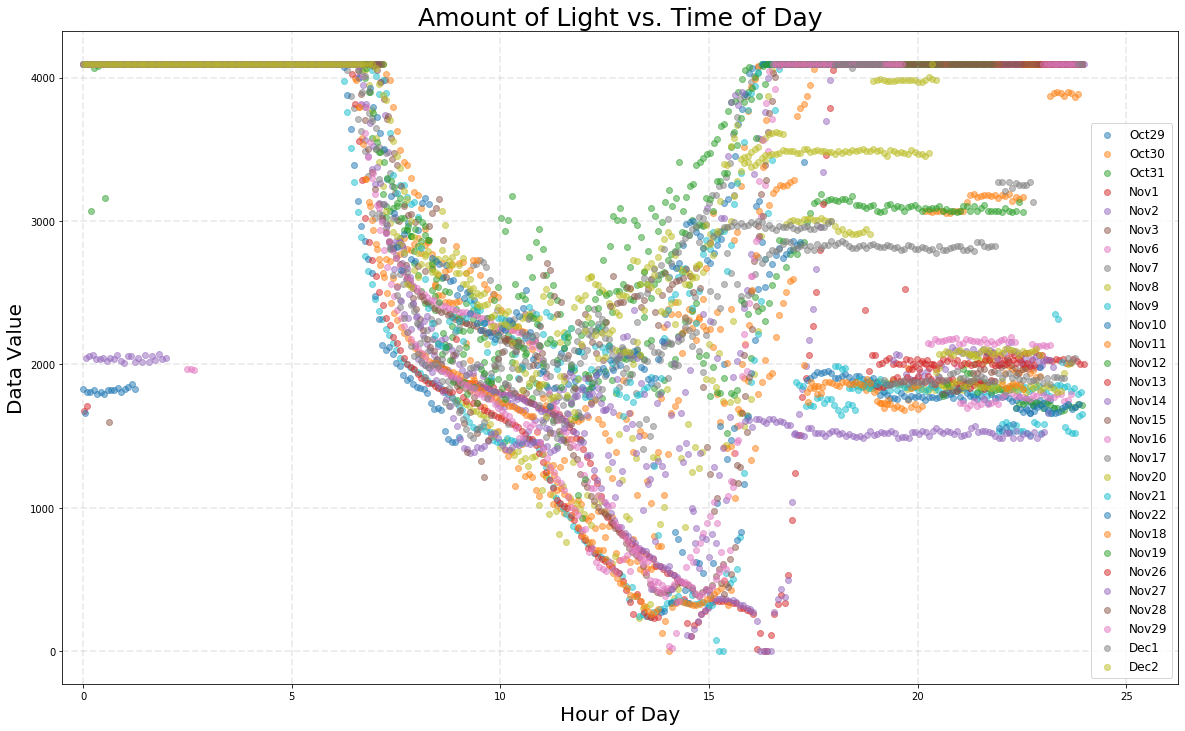

In [24]:
# Plot light data per hour per day   
plt.subplots(figsize = (20,12))

calendar_day_Oct = ['Oct29', 'Oct30','Oct31']
calendar_day_Nov = ['Nov1','Nov2','Nov3','Nov6','Nov7','Nov8','Nov9','Nov10',
                    'Nov11','Nov12','Nov13','Nov14','Nov15', 'Nov16','Nov17',
                    'Nov20','Nov21','Nov22','Nov18','Nov19','Nov26','Nov27',
                    'Nov28','Nov29']
calendar_day_Dec = ['Dec1','Dec2']

for i in range(len(calendar_day_Oct)):
    plot_days(df, data_name, indices_of_days[0][i], calendar_day_Oct[i])
for i in range(len(calendar_day_Nov)):
    plot_days(df, data_name, indices_of_days[1][i], calendar_day_Nov[i])    
for i in range(len(calendar_day_Dec)):
    plot_days(df, data_name, indices_of_days[2][i], calendar_day_Dec[i])

plt.title('Amount of Light vs. Time of Day', fontsize = 25)
# plt.plot(hours[0], ave_data_per_hr, '-or', markersize = 12, linewidth = 3, label = 'avg')
plt.legend(loc = 'lower right', fontsize = 12)
plt.xlim([-0.5,26.25])
plt.grid(True, lw=1.75, ls='--', alpha=0.25)
plt.show()

The data definitely seems to follow a pattern throughout the day and across multiple days, with values ~4000 representing no light in the early morning (before 5 am) and values decrease throughout the day, reaching lowest values (most light) between noon and 3pm, i.e. the sunniest time in my apartment. Then, the values begin to increase and approach ~4000, which makes sense as the sun is setting and again there is no natural light reaching the sensor. The data "blobs" that occur in the later hours (on the right side of the plot) seem to hover ~2000 which most likely represent when the lights were turned on in my apartment in the evening hours. To better indentify any patterns in this post sunset lighting, we plotted the amount of light by day in a calendar form.

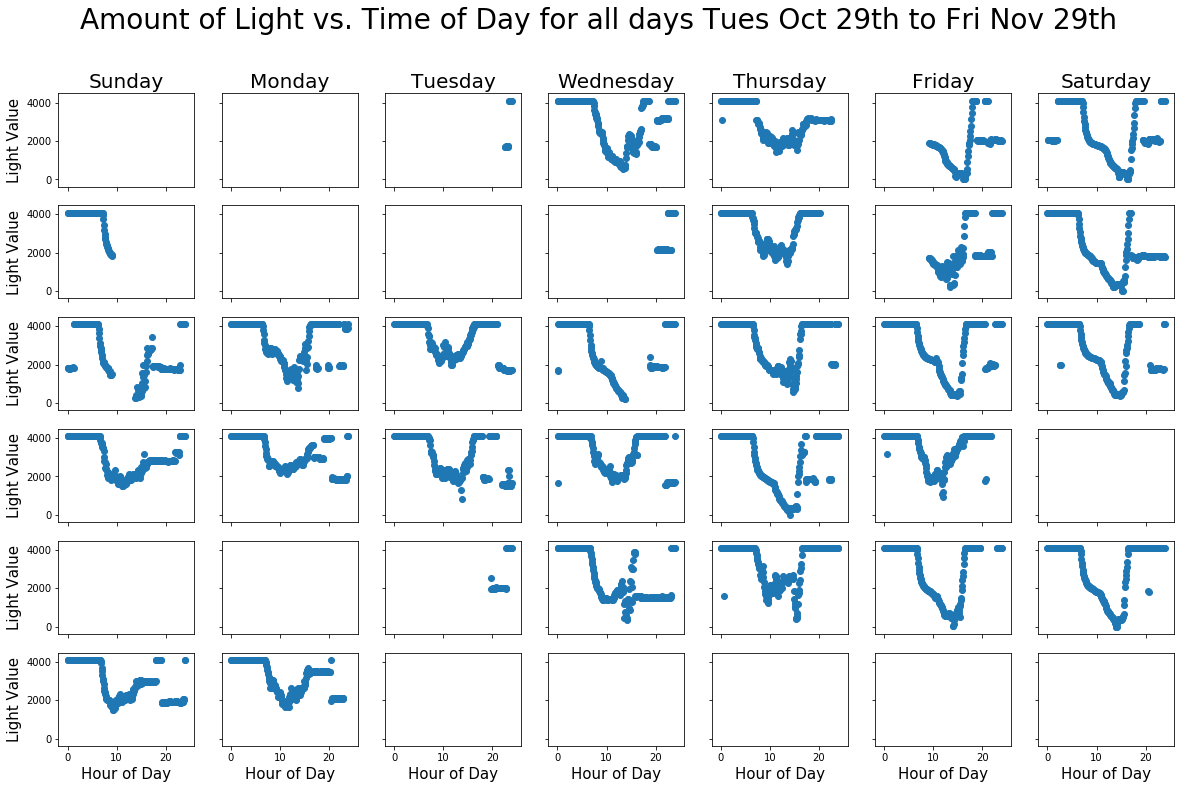

In [34]:
fig, ax = plt.subplots(6,7, figsize = (20,12), sharex=True, sharey=True)

# 'X' data
x_plot = []
for i in range(df.shape[0]):
    x_vals = df.date[i].hour + df.date[i].minute/60
    x_plot.append(x_vals)

# 'Y' data
data_days = []
for i in range(len(days[0])):
    data_by_day_Oct = df[data_name].values[indices_of_days[0][i]]
    data_days.append(data_by_day_Oct)
for i in range(len(days[1])):
    data_by_day_Nov = df[data_name].values[indices_of_days[1][i]]
    data_days.append(data_by_day_Nov)
for i in range(len(days[2])):
    data_by_day_Dec = df[data_name].values[indices_of_days[2][i]]
    data_days.append(data_by_day_Dec)

# Plot in calendar form
for i in range(28):
    if i < 3:
        ax[0,i+2].scatter(x_plot[indices_of_days[0][i][0]:indices_of_days[0][i][0] + len(indices_of_days[0][i])], 
                          data_days[i]) 
    elif 3 <= i < 5:
        ax[0,i+2].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0] + len(indices_of_days[1][i-3])], 
                          data_days[i])
    elif i == 5:
        ax[1,0].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0] + len(indices_of_days[1][i-3])], 
                        data_days[i])
    elif 6 <= i < 10:
        ax[1,i-3].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0] + len(indices_of_days[1][i-3])], 
                          data_days[i])
    elif 10 <= i < 17:
        ax[2,i-10].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0] + len(indices_of_days[1][i-3])], 
                           data_days[i])
    elif 17 <= i < 23:
        ax[3,i-17].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0] + len(indices_of_days[1][i-3])], 
                           data_days[i])
    else:
        ax[4,i-21].scatter(x_plot[indices_of_days[1][i-3][0]:indices_of_days[1][i-3][0] + len(indices_of_days[1][i-3])], 
                           data_days[i]) 
        
        
ax[5,0].scatter(x_plot[indices_of_days[2][0][0]:indices_of_days[2][0][0] + len(indices_of_days[2][0])], 
                           data_days[-2])
ax[5,1].scatter(x_plot[indices_of_days[2][1][0]:indices_of_days[2][1][0] + len(indices_of_days[2][1])], 
                           data_days[-1])
    
# Label
days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

for i in range(0,7):
    ax[0,i].set_title(days_of_week[i], fontsize = 20)
    ax[5,i].set_xlabel('Hour of Day', fontsize = 15)
    
for i in range(0,6):
    ax[i,0].set_ylabel('Light Value', fontsize = 15)
    
fig.suptitle('Amount of Light vs. Time of Day for all days Tues Oct 29th to Fri Nov 29th', fontsize = 28)
plt.show()

Due to sensor collection issues, we were not able to have consecutive collection days; however despite this missing data, we can see a pattern of light amount across the hours of the day and across days. We next plotted the averaged the data to create an "average" day (see red line in plot below). 

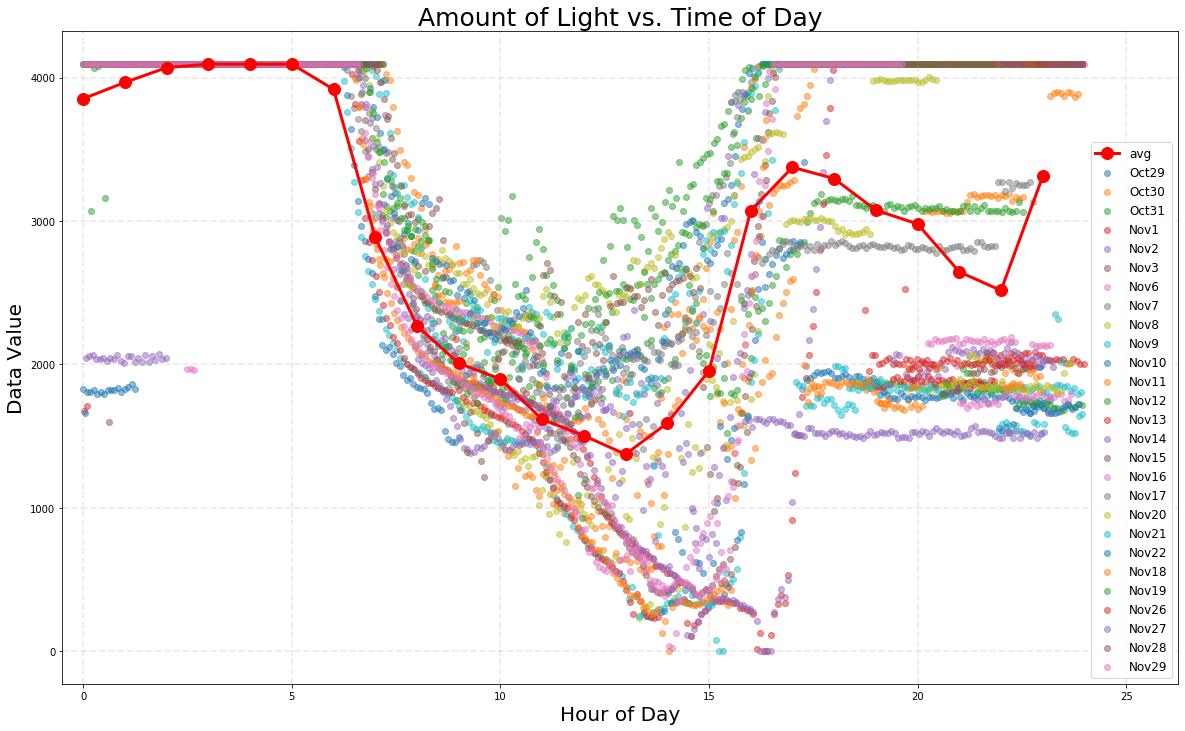

In [57]:
# Find light per hour for "average" day
ave_data_per_hr = []
for i in range(len(indices_of_hours[0])):
    hour_df = df.iloc[indices_of_hours[0][i],:]

    hour_df = hour_df.append(df.iloc[indices_of_hours[1][i],:])
    ave_data_per_hr.append(np.nanmean(hour_df[data_name]))
    
    
# Plot light data per hour per day   
plt.subplots(figsize = (20,12))

calendar_day_Oct = ['Oct29', 'Oct30','Oct31']
calendar_day_Nov = ['Nov1','Nov2','Nov3','Nov6','Nov7','Nov8','Nov9','Nov10',
                    'Nov11','Nov12','Nov13','Nov14','Nov15', 'Nov16','Nov17',
                    'Nov20','Nov21','Nov22','Nov18','Nov19','Nov26','Nov27',
                    'Nov28','Nov29']

for i in range(len(calendar_day_Oct)):
    plot_days(df, data_name, indices_of_days[0][i], calendar_day_Oct[i])
for i in range(len(calendar_day_Nov)):
    plot_days(df, data_name, indices_of_days[1][i], calendar_day_Nov[i])    
# for i in range(len(calendar_day_Dec)):
#     plot_days(df, data_name, indices_of_days[1][i], calendar_day_Dec[i])

plt.title('Amount of Light vs. Time of Day', fontsize = 25)
plt.plot(hours[0], ave_data_per_hr, '-or', markersize = 12, linewidth = 3, label = 'avg')
plt.legend(loc = 'lower right', fontsize = 12)
plt.xlim([-0.5,26.25])
plt.grid(True, lw=1.75, ls='--', alpha=0.25)
plt.show()

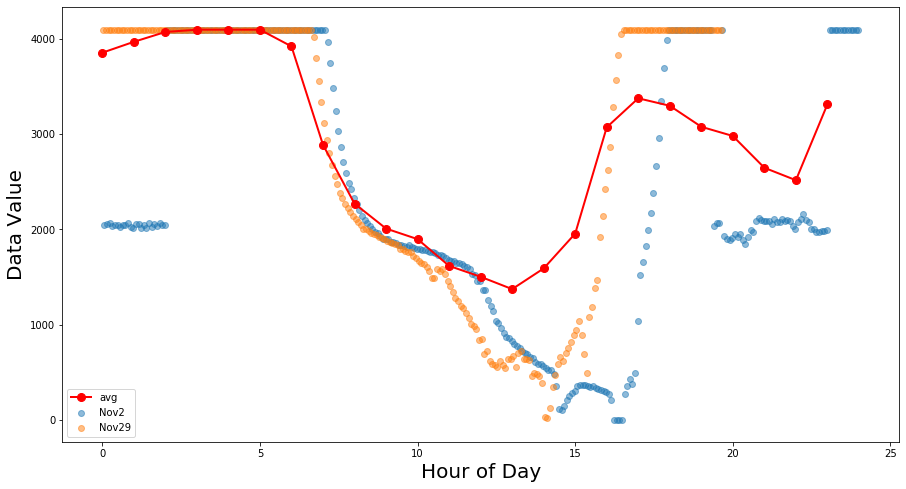

In [66]:
plt.subplots(figsize = (15,8))
plt.plot(hours[0], ave_data_per_hr, '-or', markersize = 8, linewidth = 2, label = 'avg')
plot_days(df, data_name, indices_of_days[1][1], calendar_day_Nov[1])   
plot_days(df, data_name, indices_of_days[1][23], calendar_day_Nov[23])   

"Ideal day" calls has sunrise between 6 and 7am with 

## Modeling

We were specifically interested in understanding the light that we see in the evening hours/very early morning hours, and we used our modeling approach below to begin to classify this light.

We first denoted any data with light value equal to the max light value to be 0, indicating that no light was sensed. For values less than this "off" value, we denoted data entries with a 1, indicating that there was light. We called this binary variable light_on. We added day and hour as predictors to the dataframe.

In [194]:
# 0 = light off, 1 = light on 
df['light_on'] = 0
for i,j in enumerate(df.light):
    if j < max(df.light):
        df.loc[i,'light_on'] = 1

# Add month, day and hour to data frame as predictors, drop date col
df['month']  = 0
df['day'] = 0
df['hour'] = 0
for i,dt in enumerate(df.date):
    df.loc[i,'month'] = dt.month
    df.loc[i,'day'] = dt.day
    df.loc[i,'hour'] = dt.hour

baseline_df = df.drop(columns=['date'])
baseline_df.head()

,light,light_on,month,day,hour
0,1698.0,1,10,29,22
1,1662.0,1,10,29,22
2,1707.0,1,10,29,22
3,1718.0,1,10,29,22
4,1754.0,1,10,29,22


We used the average day plot (red line) to determine the average hour of sunrise and sunset. We then used this range of daylight hours to classify whether the light source is "natural" (i.e. due to sunlight) (1), "artificial" (i.e. due to apt lighting) (2), or not present (i.e. lights are off) (0). 

In [195]:
sunrise = hours[0][5]
sunset = hours[0][-7]
print('Sunrise:', sunrise, 'AM')
print('Sunset:', sunset - 12, 'PM')

y = classify(baseline_df, sunrise, sunset)
baseline_df['light_source'] = y
baseline_df.head()

Sunrise: 5 AM
Sunset: 5 PM


,light,light_on,month,day,hour,light_source
0,1698.0,1,10,29,22,2
1,1662.0,1,10,29,22,2
2,1707.0,1,10,29,22,2
3,1718.0,1,10,29,22,2
4,1754.0,1,10,29,22,2


We performed an 80-20 train-test split, straitifying by light source.

In [196]:
X_train, X_test, y_train, y_test = train_test_split(baseline_df.loc[:, baseline_df.columns != 'light_source'], 
                                                         baseline_df.light_source, test_size=0.2, 
                                                         random_state = 109, stratify = baseline_df.light_source)

print(baseline_df.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(baseline_df.light_source.value_counts(normalize=True))

(6336, 6)
(5068, 5) (1268, 5) (5068,) (1268,)
1    0.458333
0    0.373422
2    0.168245
Name: light_source, dtype: float64


We decided to fit a decision tree model to our training data because our outcome variable has 3 categories: light off, natural light, and artificial light. To determine the best tree depth, we chose a range of tree depths from 1 to 5 and evaluated the performance and standard deviations for each depth using 5-fold cross-validation. We plotted the estimated mean +/- 2 standard deviations for each depth. 

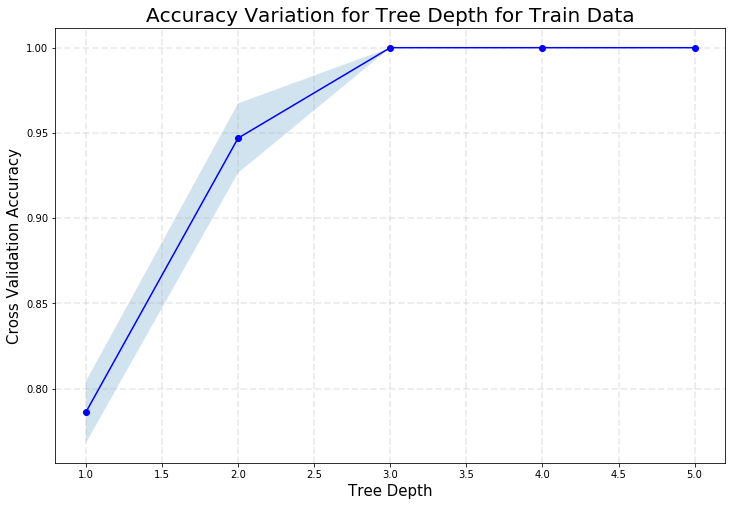

In [197]:
depths = list(range(1, 6))

def calc_meanstd(X_train, y_train, depths):
    cvmeans = {}
    cvstds = {}
    train_scores = {}
    for i in depths:
        model = DecisionTreeClassifier(max_depth=i)
        score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
        train_scores[i] = score
        cvmeans[i] = score.mean()
        cvstds[i] = score.std()
    return cvmeans, cvstds, train_scores\

cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

#Plot the estimated mean +/- 2 standard deviations for each depth
x = list(cvmeans.keys())
y = list(cvmeans.values())

upperbound = [y[i] + list(cvstds.values())[i]*2 for i in range(len(depths))]
lowerbound = [y[i] - list(cvstds.values())[i]*2 for i in range(len(depths))]

plt.subplots(figsize = (12,8))
plt.fill_between(x, upperbound, lowerbound, alpha=0.2, label = '+/- 2 std')

plt.ylabel('Cross Validation Accuracy', fontsize = 15)
plt.xlabel('Tree Depth', fontsize = 15)
plt.title('Accuracy Variation for Tree Depth for Train Data', fontsize = 20)
plt.plot(x, y, 'b-', marker='o', label = 'train data')
plt.grid(True, lw=1.75, ls='--', alpha=0.25)
plt.show()

In the above plot, we found that a tree depth of 2 returned the highest accuracy score (without overfitting to 100%). We fit the train data using this depth and reported the accuracy scores on the train and test sets. 

In [198]:
tree_depth = 2

best_model = DecisionTreeClassifier(max_depth=tree_depth)
best_model.fit(X_train, y_train)

train_score = 100*accuracy_score(y_train, best_model.predict(X_train))
test_score = 100*accuracy_score(y_test,  best_model.predict(X_test))

print("Decision Tree of Depth 2, Accuracy of Training Set: {:0.2f}%".format(train_score))
print("Decision Tree of Depth 2, Accuracy of Testing Set: {:0.2f}%".format(test_score))

Decision Tree of Depth 2, Accuracy of Training Set: 94.69%
Decision Tree of Depth 2, Accuracy of Testing Set: 95.90%


These high accuracy scores would be expected in this case because we have a limited number of predictors and the data already seems to have some kind of trend/pattern to it (i.e. change in light over time of day). 